# INM706 Deep Learning for Sequence Analysis
### Sarah Rhalem (190051884) & Stelios Kliafas (########)

Draft Notes/ Working comments:
Dataset >> Problem +Evaluation Metric >> Model

In [2]:
#!pip install transformers

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
import json
import torch
import re
import numpy as np
import pandas as pd
import csv
import random
import time
import random
import datasets
from tqdm.notebook import tqdm
import torch.nn as nn
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader, random_split, SequentialSampler, RandomSampler
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, AdamW, get_linear_schedule_with_warmup
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.nist_score import corpus_nist

In [2]:
# Set to use GPU on device if available:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Working directory
os.getcwd()

'C:\\Users\\sarah\\Documents\\MSc AI 2020_2021\\INM706\\INM706_DL_Sequence_Analysis'

In [4]:
# Load csv dataset, create listing column
raw_dataset_df= pd.read_csv(os.path.join("Data\\netflix_titles.csv") , encoding="utf8")
raw_dataset_df["listing"]= raw_dataset_df["listed_in"].str.split(pat=",", n=1).str.get(0)

# Cleanse Data
raw_dataset_df["description"].isna().sum() # Check null entries for description - None
raw_dataset_df["plot_description"]=raw_dataset_df["description"].map(lambda x: re.sub( r'"', '', x)) #remove quotation marks

# Print example of plot description
raw_dataset_df["description"].to_list()[0]

'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'

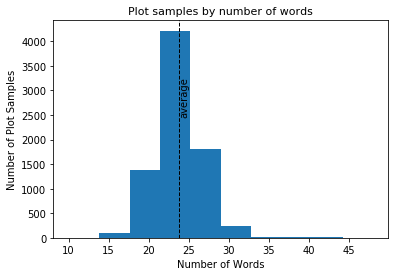

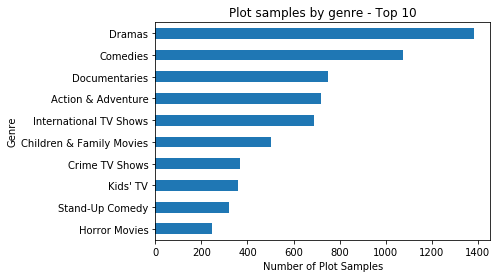

In [5]:
# Exploratory Data Analysis for the Netflix Plot Dataset

# Maximum length of plot description is < 45 words. Max length of generation will be set to ~50 
raw_dataset_df['Number_of_words'] = raw_dataset_df.description.apply(lambda x: len(str(x).split(' ')))
x=raw_dataset_df['Number_of_words']
plt.hist(raw_dataset_df['Number_of_words'])
plt.title("Plot samples by number of words", fontsize=11)
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.text(x.mean() ,2500 ,'average',rotation=90)
plt.xlabel('Number of Words')
plt.ylabel('Number of Plot Samples')
#plt.savefig(os.path.join(path, r'XXXXXXX.jpg'), dpi=300, bbox_inches='tight')
plt.show()

# Plots by genre (top 10) - will map all genres to top 10 genres
#genre_count= raw_dataset_df['listing'].value_counts()
raw_dataset_df.listing.value_counts()[:10].sort_values().plot(kind = 'barh')
plt.title("Plot samples by genre - Top 10")
plt.xlabel("Number of Plot Samples")
plt.ylabel('Genre')
plt.show()

In [6]:
# Map each data sample listing to a generic genre
 
 # Identify the show listings for mapping to summarised genres
raw_dataset_df.listing.value_counts()

# map show listing to a specific genre. Note: Listing types with under ~100 data samples are classified under the genre "Other"
genre_mapping= { "romance": {"Romantic TV Shows", "Romantic Movies"} ,
                "drama": {"Dramas", "TV Dramas"}  ,
                 "comedy": {"Comedies", "Stand-Up Comedy", "TV Comedies", "Stand-Up Comedy & Talk Shows"},
                 "documentary": {"Documentaries", "Docuseries"},
                 "action": {"Action & Adventure", "TV Action & Adventure"} ,
                 "international": {"International TV Shows", "International Movies", "Spanish-Language TV Shows"},
                 "children": {"Children & Family Movies", "Kids' TV"},
                 "crime": {"Crime TV Shows"},
                 "horror": {"Horror Movies", "TV Horror"} ,
                 "anime" : {"Anime Series", "Anime Features"},
                 "other" : {"Thrillers", "British TV Shows", "Reality TV", "Classic & Cult TV", "TV Shows", "TV Sci-Fi & Fantasy",
                         "Classic Movies", "Movies", "Independent Movies", "Cult Movies", "Sports Movies", "LGBTQ Movies", "Music & Musicals",
                         "Sci-Fi & Fantasy"} }

# function to map listings to genres by dictionary key
def map_function(dictionary):
    def my_map(x):
        res = ""
        for key in dictionary.keys():
            if (x in dictionary[key]):
                res = key
                break
        return res
    return my_map

# Add genre column based on listing mapping
raw_dataset_df["genre"] = raw_dataset_df["listing"].map(map_function(genre_mapping))

# Write to txt file
plot_dataset_df= raw_dataset_df[["genre","plot_description"]].copy()
plot_dataset= plot_dataset_df.to_csv('Data\\netflix_plot_dataset.txt', index=False, header=None, sep=":", doublequote=False )

# Sense check - view data header and check all descriptions were mapped
print(plot_dataset_df.head())
print(plot_dataset_df.genre.unique())

           genre                                   plot_description
0  international  In a future where the elite inhabit an island ...
1          drama  After a devastating earthquake hits Mexico Cit...
2         horror  When an army recruit is found dead, his fellow...
3         action  In a postapocalyptic world, rag-doll robots hi...
4          drama  A brilliant group of students become card-coun...
['international' 'drama' 'horror' 'action' 'crime' 'documentary' 'other'
 'comedy' 'anime' 'children' 'romance']


In [7]:
# Load Tokenizer and config 
configuration = GPT2Config.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set pad token to eos token. Padding for GPT-2 occurs on the right so will be set to eos token.
configuration.pad_token_id = configuration.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

# Define special tokens to be used
special_tokens_dict = {
                "bos_token": "<genre>",
                 "sep_token":"<plot>",
                 "unk_token": "<unknown>"
            }
# Add special tokens 
num_of_toks= tokenizer.add_special_tokens(special_tokens_dict)
print('We have added', num_of_toks, 'tokens')


We have added 2 tokens


In [8]:
# Dataset Class
class NetflixPlotDataset(Dataset):
          def __init__(self, tokenizer=tokenizer, dataset_path=os.path.join("Data\\netflix_plot_dataset.txt"), block_size=50): # Block size set to max length of data 

            bos_tkn= tokenizer.bos_token
            sep_tkn= tokenizer.sep_token
            eos_tkn= tokenizer.eos_token
            
            # Load dataset txt file line by line
            plot_file = open(os.path.join(dataset_path), encoding="utf-8")
            lines =[]
            for line in plot_file.read().splitlines():
                if (len(line) > 0 and not line.isspace()):
                    try:
                        lines+= [bos_tkn+line[:line.index(':')]+ " :"+ sep_tkn+line[line.index(':')+1:]+ eos_tkn]
                    except ValueError:
                        raise ValueError('line '+line+' does not contain ":"')
            
            # Encode plot data with addition of special tokens for line by line loading
            self.input_ids = tokenizer.batch_encode_plus(lines, add_special_tokens=True, max_length=block_size, truncation=True, padding='max_length')["input_ids"] 

        
          def __len__(self):
            return len(self.input_ids)

          def __getitem__(self, i):
            return torch.tensor(self.input_ids[i], dtype=torch.long)

In [9]:
# Instantiate dataset and return length
dataset=NetflixPlotDataset()
dataset.__len__()

7786

In [10]:
# Example of decoded tokenizer plot sample from the dataset.
tokenizer.decode(dataset[23])

'<genre> drama : <plot> When a middle-aged divorcee returns to Kolkata to visit his ailing father, long-buried memories resurface, bringing new discoveries with them.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [11]:
# Split dataset into train, val and test subsets and create dataloaders - 70% train, 20% val, 10% test

# Set batch size
BATCH_SIZE=10

def split_datasets_and_create_dataloaders(dataset, seed=10, batch_size=BATCH_SIZE):
  
    train_len= int(0.7 * len(dataset)) 
    val_len= int(0.2* len(dataset))
    test_len= int(len(dataset)-(train_len + val_len))
    
    lengths=[train_len, val_len, test_len]
                              
    train_subset, val_subset, test_subset = random_split(dataset, lengths, torch.Generator().manual_seed(seed))
                              
    print("Number of Training samples:", len(train_subset))
    print("Number of Validation samples:", len(val_subset))
    print("Number of Testing samples:", len(test_subset))

    train_dataloader = DataLoader(
              train_subset,
              batch_size = batch_size,
              shuffle = True
          )

    val_dataloader = DataLoader(
              val_subset,
              batch_size = batch_size,
              shuffle = False
          )
    
    test_dataloader = DataLoader(
              test_subset,
              batch_size = batch_size,
              shuffle = False
          )
  
    dataloaders = {'train_dataloader': train_dataloader, 'val_dataloader': val_dataloader,'test_dataloader': test_dataloader}
    
    return dataloaders

In [12]:
#  Checkpoint saving and loading methods

def save_checkpoint(state, checkpoint_path):
    print("Saving checkpoint ... ")
    torch.save(state, checkpoint_path)
    print("Checkpoint:", checkpoint_path, "saved.")


def load_checkpoint(model, optimizer, scheduler, load_checkpoint_path):
    print("Loading checkpoint ... ")
    checkpoint = torch.load(load_checkpoint_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, scheduler, start_epoch

In [13]:
# Time and seed util methods 

def format_time(start_time,end_time):
    hours, remainder = divmod(end_time - start_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return ("{:0>2}:{:0>2}:{:0>2}".format(int(hours), int(minutes), int(seconds)))

def set_seed():
    random.seed(10)
    np.random.seed(10)
    torch.manual_seed(10)
    torch.cuda.manual_seed_all(10)

## Fine-tuning GPT-2 

### Training & Validation

In [24]:
# Training and validation method to fine-tune the model on the Netflix plot dataset


# load Dataloaders
BATCH_SIZE=10
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=BATCH_SIZE)

# Training/Validation method
def train_val(model, dataloaders, starting_epoch, optimizer, scheduler, epochs, device):
    print("\n\n" + "-" * 15)
    print("| TRAINING... |")
    print("-" * 15)
    set_seed()
    start_training_time = time.time()
    
    # Define running history for train and val
    train_loss_history=[]
    val_loss_history=[]
    train_perplexity_history=[]
    val_perplexity_history=[]
    
    # Training loop
    for epoch in range(starting_epoch, epochs): 
        train_loss=0
        model.train()     
        for step, batch in tqdm(enumerate(dataloaders['train_dataloader']), total=len(dataloaders['train_dataloader'])):
                # Load and feed data to model
                input_ids = batch.to(device)
                model.zero_grad()        
                outputs = model(input_ids, labels=input_ids)
                
                loss = outputs[0]
                batch_loss = loss.item()  
                train_loss += batch_loss
                
                if step % 200 == 199:
                    print("Epoch:",epoch+1, "/", epochs, "Batch:", step+1, "/", len(dataloaders['train_dataloader']), "Loss", train_loss/200) 
                    train_loss=0.0
                
                # Generates a model output including special tokens in order to visualise the training process and model learning
                model.eval()
                if step % 100 == 0 and step != 0:
                        samples = model.generate( #decoder_start_token_id=50258,
                                                bos_token_id=50257,
                                                do_sample=True,   
                                                top_k=50,
                                                max_length = 50,
                                                min_length = 15,
                                                top_p = 0.95,
                                                num_return_sequences=1,
                                                repition_penalty=1.1,
                                                no_repeat_ngram_size = 2,
                                                temperature=1.1
                                            )

                        for i, sample in enumerate(samples):
                                  print("{}".format(tokenizer.decode(sample, skip_special_tokens=False)))
                
                # Return to train mode and backpropagate loss
                model.train()
                loss.backward()
                # Apply gradient clipping
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                # Optimzer/Learning rate schedular step
                optimizer.step()
                scheduler.step()
                
                torch.cuda.empty_cache()
                
        # Loss and perplexity results by epoch        
        end_epoch_time = time.time()
        epoch_train_loss = train_loss / len(dataloaders['train_dataloader'])
        epoch_train_perplexity= torch.exp(torch.tensor(epoch_train_loss))     
        epoch_train_time = format_time(start_training_time, end_epoch_time)
        train_loss_history.append(epoch_train_loss)
        train_perplexity_history.append(epoch_train_perplexity)
        
        print(f' epoch: {epoch + 1}, train loss: {epoch_train_loss:.6f}, train ppl: {epoch_train_perplexity:.6f}, train time:{epoch_train_time}')

        # Switch to evaluation mode and run validation
        print("Validating...")
        
        start_val_time = time.time()
        model.eval()
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for step, batch in tqdm(enumerate(dataloaders['val_dataloader']),total=len(dataloaders['val_dataloader'])):        
                        input_ids = batch[0].to(device)
                        outputs  = model(input_ids, labels=input_ids)          
                        loss = outputs[0]
                        # loss, logits= outputs[:2] # outputs has two elements loss and logits
                        batch_loss = loss.item()  
                        val_loss += batch_loss
                        
                        torch.cuda.empty_cache()
                        end_val_time = time.time()
            
        epoch_val_time = format_time(start_val_time, end_val_time)
        epoch_val_loss = val_loss/ len(dataloaders['val_dataloader'])
        epoch_val_perplexity= torch.exp(torch.tensor(epoch_val_loss))
        val_loss_history.append(epoch_val_loss)
        val_perplexity_history.append(epoch_val_perplexity)
        #print("Validation time: ", epoch_val_time)  

        print(f' epoch: {epoch +1}, val loss: {epoch_val_loss:.6f}, val ppl: {epoch_val_perplexity:.6f}, val_time: {epoch_val_time}')
        
        # Record results to dictionary to return
        performance_history = {}
        performance_history['train_loss']=train_loss_history
        performance_history['val_loss']=val_loss_history
        performance_history['train_perplexity']=train_perplexity_history
        performance_history['val_perplexity']=val_perplexity_history
        
        # Save model checkpoint at end of train_val run, also saves performance history
        if epoch == epochs-1:
            checkpoint = {
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),
              'performance_history': performance_history,
              'epoch': epoch + 1,
              }
           # save_checkpoint(checkpoint, f"./checkpoint_{checkpoint['epoch']}.pth.tar")
        print("")
        print("Training Finished")
        

    return performance_history

Number of Training samples: 5450
Number of Validation samples: 1557
Number of Testing samples: 779


In [25]:
# Re-Instantiate model and corresponding config file, reapply resizing for token embeddings
# Re-run before train_val method is called to ensure that the pretrained model is not being updated after every train call during hyperparameter tuning
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer)) # resize token embeddings as model is instantiated

#Hyperparameters
EPOCHS=4  
DEVICE='cuda:0'
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


# Run train_val
Test_1= train_val(model, dataloaders,starting_epoch=0, optimizer=OPTIM, scheduler=SCHEDULER, epochs=EPOCHS, device=DEVICE)





---------------
| TRAINING... |
---------------


<genre>  to <genre> <genre>. <genre>  million, divided divided. million-million. millions-and, in addition to, and, during the last time,- for the purposes of being, each being.<|endoftext|>
Epoch: 1 / 4 Batch: 200 / 545 Loss 23.402840867042542
<genre> comedy : <genre> A family living in a rural Connecticut town discovers something strange when they turn their back on a supernatural family for their money.<|endoftext|>
<genre> comedy : <plot> An eccentric comedian tries to reconnect with his parents through his own comedy but is caught up in his dysfunctional family life.<|endoftext|>
Epoch: 1 / 4 Batch: 400 / 545 Loss 2.5300043427944185
<genre> comedy : <plot> An 18-year-old girl is on the run after being left behind at a school with her boyfriend.<|endoftext|>
<genre> anime : <plot> A boy's best friend gets a sudden boost after the loss of his mentor, becoming the new school's president.<|endoftext|>

 epoch: 1, train loss: 0.649822, train ppl: 1.915199, train time:00:02:08
Validatin


 epoch: 1, val loss: 2.304201, val ppl: 10.016173, val_time: 00:00:02

Training Finished


<genre> comedy : <plot> At first glance, it may look funny, but once you have the ability to laugh, you'll be better off. Inspired by this video, writer and actor Josh Holmes shares his thoughts on creating the best sitcom show ever.
Epoch: 2 / 4 Batch: 200 / 545 Loss 2.2805936563014986
<genre> international : <plot> This intimate, intimate documentary features true-life relationships between Japanese celebrities and the most renowned stars of their time.<|endoftext|>
<genre> comedy : <plot> Comedian Tim Allen reflects on his career and past, the ways he grew up, and the ups, downs and highs of acting in the film world.<|endoftext|>
Epoch: 2 / 4 Batch: 400 / 545 Loss 2.2774541449546812
<genre> drama : <plot> Tired of an easy life, a struggling actor goes to work on his Broadway career — and ends up with a stench of corruption that only widens his agony.<|endoftext|>
<genre> comedy : <plot> Granite millionaire Larry Meeks's wife Jo, whom he recently divorced, is an aspiring stage manage


 epoch: 2, val loss: 2.251797, val ppl: 9.504803, val_time: 00:00:02

Training Finished


<genre> comedy : <plot> Hosting a comedy show featuring funny, absurdist voices, director Mike Birbiglia takes on the world and politics of fame and comedy.<|endoftext|>
Epoch: 3 / 4 Batch: 200 / 545 Loss 2.14542666554451
<genre> comedy : <plot> Beside the grave and the broken family, a young couple with autism navigate a turbulent family landscape in rural Nigeria, until their tumultuous marriage unravels into a scandal.<|endoftext|>
<genre> action : <plot> When their secret lives are betrayed by two powerful friends, a trio of men with mysterious powers go underground in an effort to stop a terrorist's plans.<|endoftext|>
Epoch: 3 / 4 Batch: 400 / 545 Loss 2.1590075439214704
<genre> comedy : <plot> This documentary focuses on the legendary late Jack London. Based on his work that ran for almost 40 years as a radio jockey in England.<|endoftext|>
<genre> drama : <plot> A widowed former porn executive begins to realize that her husband has been a huge influence on his life – and the fa


 epoch: 3, val loss: 2.217283, val ppl: 9.182344, val_time: 00:00:02

Training Finished


<genre> drama : <plot> After falling prey to seductive visions, a young high schooler finds herself in love with an older woman, but at first, the romance is far from settled.<|endoftext|>
Epoch: 4 / 4 Batch: 200 / 545 Loss 2.0749827647209167
<genre> comedy : <plot> Comedian Zach Galifianakis delivers unflinching sketches about American foreign policy from his apartment in Miami to his home in Los Angeles.<|endoftext|>
<genre> comedy : <plot> Featuring an array of outrageous personal stories and heartfelt moments, this biopic stars Paul Dano, who's come a long way since his breakout hit: Last of the Mohicans.<|endoftext|>
Epoch: 4 / 4 Batch: 400 / 545 Loss 2.0800765770673753
<genre> international : <plot> A young woman who lives alone, with a family at her side, learns that all she knows is love. But she must choose between love and peace with all her friends.<|endoftext|>
<genre> action : <plot> The war against the Vax is waged against five powerful allies of humanity's elite force: t


 epoch: 4, val loss: 2.217822, val ppl: 9.187298, val_time: 00:00:02
Saving checkpoint ... 


C:\Users\sarah\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Checkpoint: ./checkpoint_4.pth.tar saved.

Training Finished


In [19]:
# Plotting methods for training/validation

# Combined plots train/val

def plot_train_val_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_loss'])+1)
    plt.plot(epoch_count, (history['train_loss']), label='Training Loss')
    plt.plot(epoch_count, (history['val_loss']), label='Validation Loss')
    plt.ylim(0,2.5)
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_train_val_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_perplexity'])+1)
    plt.plot(epoch_count, (history['train_perplexity']), label='Train perplexity')
    plt.plot(epoch_count, (history['val_perplexity']), label='Validation perplexity')
    plt.xticks(epoch_count)
    plt.ylim(0,12)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

# Individual plots for train and val to visualise to scale

def plot_train_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_loss'])+1)
    plt.plot(epoch_count, (history['train_loss']), label='Training Loss')
    plt.ylim(0,1)
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_val_loss(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['val_loss'])+1)
    plt.plot(epoch_count, (history['val_loss']), label='Validation Loss')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig
def plot_train_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['train_perplexity'])+1)
    plt.plot(epoch_count, (history['train_perplexity']), label='Train perplexity')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig 

def plot_val_perplexity(history, title):
    fig= plt.figure()
    epoch_count= range(1, len(history['val_perplexity'])+1)
    plt.plot(epoch_count, (history['val_perplexity']), label='Validation perplexity')
    plt.xticks(epoch_count)
    plt.xlabel("epochs")
    plt.ylabel("perplexity")
    plt.title(title)
    plt.legend()
    plt.show()
    return fig

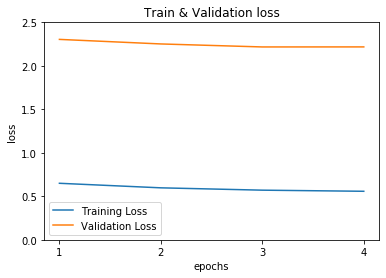

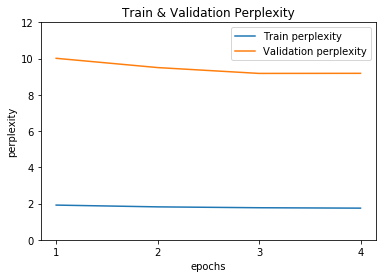

In [26]:
# Display Train & Validation loss and perplexity plots

fig= plot_train_val_loss(Test_1, "Train & Validation loss");
#fig.savefig(r'Figures\\train_val_loss_4eps_crop.jpg')

fig= plot_train_val_perplexity(Test_1, "Train & Validation Perplexity");
#fig.savefig(r'Figures\\train_val_perplexity_4eps_crop.jpg')

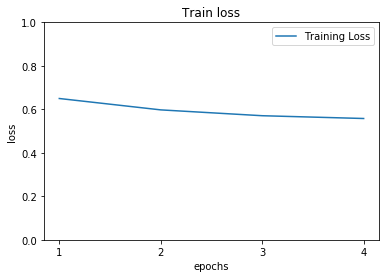

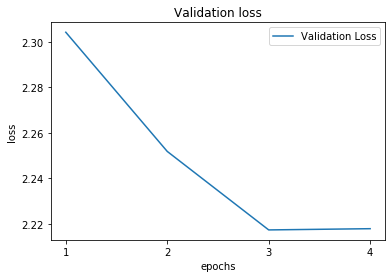

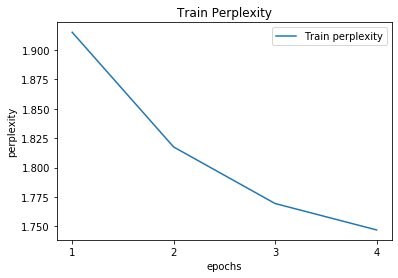

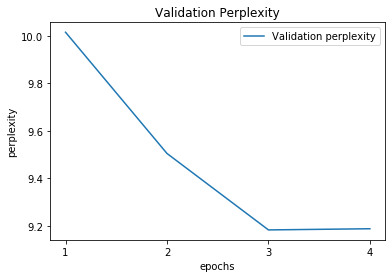

In [27]:
# Plot train/val loss and perplexity
fig= plot_train_loss(Test_1, "Train loss");
#fig.savefig(r'Figures\\train_loss_4eps.jpg')

fig= plot_val_loss(Test_1, "Validation loss");
#fig.savefig(r'Figures\\val_loss_4eps.jpg')

fig= plot_train_perplexity(Test_1, "Train Perplexity");
#fig.savefig(r'Figures\\train_perplexity_4eps.jpg')

fig= plot_val_perplexity(Test_1, "Validation Perplexity");
#fig.savefig(r'Figures\\val_perplexity_4eps.jpg')


In [28]:
Test_1

{'train_loss': [0.6498215084775872,
  0.5974848115116085,
  0.5706477733927036,
  0.5578646495801594],
 'val_loss': [2.3042011566651173,
  2.2517972137683477,
  2.217282539758927,
  2.21782193504847],
 'train_perplexity': [tensor(1.9152),
  tensor(1.8175),
  tensor(1.7694),
  tensor(1.7469)],
 'val_perplexity': [tensor(10.0162),
  tensor(9.5048),
  tensor(9.1823),
  tensor(9.1873)]}

## Evaluating fine-tuned GPT-2 model 

### Testing and generating plots

In [14]:
# Instantiate model, apply resizing for token embeddings - re-run instantiation before training
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

BATCH_SIZE=10
dataloaders = split_datasets_and_create_dataloaders(dataset, batch_size=BATCH_SIZE)

EPOCHS=10
DEVICE='cuda:0'
TRAIN_STEPS= len(dataloaders['train_dataloader'])*EPOCHS
WU_RATE= 0.2
WU_STEPS= TRAIN_STEPS * WU_RATE# Warm up rate of ~0.2% 
OPTIM= AdamW(model.parameters(), lr = 3e-5,eps = 1e-8, weight_decay=0.01)
SCHEDULER= get_linear_schedule_with_warmup(optimizer=OPTIM, num_warmup_steps =WU_STEPS, num_training_steps =TRAIN_STEPS)


def load_checkpoint(model, optimizer, scheduler, load_checkpoint_path):
    print("Loading checkpoint ... ")
    checkpoint = torch.load(load_checkpoint_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, scheduler, start_epoch

load_checkpoint(model, optimizer=OPTIM, scheduler=SCHEDULER, load_checkpoint_path= "checkpoint_4.pth.tar")

Number of Training samples: 5450
Number of Validation samples: 1557
Number of Testing samples: 779
Loading checkpoint ... 


C:\Users\sarah\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:234: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(GPT2LMHeadModel(
   (transformer): GPT2Model(
     (wte): Embedding(50259, 768)
     (wpe): Embedding(1024, 768)
     (drop): Dropout(p=0.1, inplace=False)
     (h): ModuleList(
       (0): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
         )
         (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (mlp): MLP(
           (c_fc): Conv1D()
           (c_proj): Conv1D()
           (dropout): Dropout(p=0.1, inplace=False)
         )
       )
       (1): Block(
         (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         (attn): Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.1, inplace=False)
           (resid_dropout): Dropout(p=0.1, inplace=False)
  

In [15]:
def generate_text(num_samples,input_genres=None):
    
   # Generate plot samples based on Top-k and Top-p filtering and sampling methods available with HuggingFace model.generate method
    
   # set_seed() # Note: Seed is set in test method, enabling seed here impacts random choice of input genre 
    generated_plots=[]
    model.eval()
    with torch.no_grad():
        
        bos_tkn=tokenizer.bos_token
        sep_tkn=tokenizer.sep_token
        eos_tkn=tokenizer.eos_token

        # Input prompt for text generation is a randomly selected genre from our genre list.
        genre_list=["romance", "drama", "comedy", "documentary", "action", "international",
                   "children", "crime", "horror", "anime", "other"]
        # Select random genre or user specified genre 
        for i in range (num_samples):
                if(input_genres is None):
                    genre= random.choice(genre_list)
                else:
                    genre = input_genres[i]
                    
                prompt= bos_tkn + genre + ": " + sep_tkn  
                prompts= (torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)).to(device)
                
                #
                samples= model.generate(prompts, # input genre 
                                        do_sample=True,   
                                        top_k=50,
                                        min_length=15,
                                        max_length = 50,
                                        top_p = 0.95,
                                        num_return_sequences=1,
                                        repitition_penalty=1.1,
                                        no_repeat_ngram_size = 2,
                                        temperature=1.1
                                    )

                generated_plot= "{}".format(tokenizer.decode(samples[0], skip_special_tokens=True, ))
                #print(len(samples))
                #print(generated_plot)
                generated_plots.append(generated_plot)
        
    return generated_plots



In [16]:
#Evaluates the test dataset on the fine-tuned model. Calculates the BLEU score based on generated samples from the model vs input
# plot samples. 

def test_generate(model, dataloaders, device):
    model.eval()
    metric= datasets.load_metric('sacrebleu') 
    set_seed()
    
    with torch.no_grad():
        test_loss=0
        plots=[]
        references=[]
        
        for step, batch in tqdm(enumerate(dataloaders['test_dataloader']),total=len(dataloaders['test_dataloader'])): 
                        
                        input_ids = batch.to(device)
                        outputs= model(input_ids, labels=input_ids)          
                        loss, logits= outputs[:2]
                        batch_loss = loss.item()  
                        test_loss += batch_loss
                        
                        
                        # List of genre decoded from each input_id 
                        genre_list = []
                        # Pass input_id to references for BLEU score comparison with generated samples
                        for input_id in input_ids:#
                            reference= tokenizer.decode(input_id, skip_special_tokens=True)
                            x=reference.split()[0]
                            references.append([reference])
                            genre_list.append(x)

                        
                        # Generate sample using the same input genre as input_id
                        generate= generate_text(num_samples=len(input_ids),input_genres=genre_list)
                        plots+= generate
                        
                        
                        torch.cuda.empty_cache()
       
        #Smoothing function for BLEU score
        cc=SmoothingFunction()
        
        #bleu_score1= corpus_bleu(references, plots, weights=(1,0,0,0),smoothing_function=cc.method1)
        # BLEU score with default settings
        bleu_score_default= corpus_bleu(references, plots, smoothing_function=cc.method1)
        
        #BLEU score with modified weights to penalize higher n-gram precision
        bleu_score_modified1= corpus_bleu(references, plots, weights=(0.5,0.25,0.25,0),smoothing_function=cc.method1)
        bleu_score_modified2= corpus_bleu(references, plots, weights=(0.5,0.5),smoothing_function=cc.method1)
        
        # Loss and perplexity results
        mean_test_loss = test_loss/ len(dataloaders['test_dataloader'])
        mean_test_perplexity= torch.exp(torch.tensor(mean_test_loss))
 
        
        print(f'test loss: {mean_test_loss:.6f}, test ppl: {mean_test_perplexity:.6f}, bleu score default:{bleu_score_default}, bleu score modified 1: {bleu_score_modified1}, bleu score modified 2: {bleu_score_modified2}')
        
        # Save test_performance
        test_performance= {}
        test_performance['mean_test_loss']=mean_test_loss
        test_performance['mean_test_perplexity']=mean_test_perplexity
        test_performance['bleu_score_default']=bleu_score_default
        test_performance['bleu_score_modified1']=bleu_score_modified1
        test_performance['bleu_score_modified2']=bleu_score_modified2
    return test_performance, references, plots

In [17]:
test_run= test_generate(model, dataloaders, device)


test loss: 2.220552, test ppl: 9.212419, bleu score default:0.2656229884281992, bleu score modified 1: 0.4615032366702634, bleu score modified 2: 0.5757460040325079


In [56]:
# Generate 20 plot samples for human analysis and evaluation
set_seed()
test_samples= generate_text(num_samples=20) 
plot_samples_csv(test_samples, "results/generated_plots_10.csv")

print(*test_samples, sep="\n")


anime:Comforting a single mom, a young teenager must choose between a high school crush, her friend who has a crush on her, and his brother who is dating a sweet girl.
romance:Marilyn learns how to seduce the guy behind her door, but the woman he has to woo doesn't like it.
children:In this reality series, three different characters — the princess the dragon, his loyal pal Balrog, and two paladin pals, The Black Watch and Pakey — stand against a group of evil sorcerers.
crime:After years of hiding her identity, a teenage girl and her gang of killers leave behind evidence to identify them as members of a notorious underground cult.
anime:The most celebrated samurai, an ace knight in the Karate National Power School, joins an army to defend a kidnapped nobleman after he is threatened by the dragon.
romance:Coyote and his friends fall in love, but only with his own family. When a new friend unexpectedly reveals herself, they battle for all their feelings.
documentary:Historian and activis

In [21]:
# Methods to save results and save plot samples to csv

def save_test_results (results, filename ):
    
    test_performance= results[0]
    with open (filename, 'wb') as handle:
        pickle.dump(test_performance, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_test_results (filename):
    with open (filename, 'rb') as handle:
        test_performance=pickle.load(handle)
    return test_performance
def plot_samples_csv(generated_plots, plot_samples_path):
    input_list= zip(generated_plots)
    with open (plot_samples_path, "w", newline="") as myfile:
        write= csv.writer(myfile, quoting=csv.QUOTE_ALL)
        for row in input_list:
            write.writerow(row)
    return



In [26]:
# Load results from test runs for models trained on 4, 5, 10 and 15 epochs.

test_results_4eps=load_test_results("Results/test_results_4eps.pickle")
test_results_5eps=load_test_results("Results/test_results_5eps.pickle")
test_results_10eps=load_test_results("Results/test_results_10eps.pickle")
test_results_15eps=load_test_results("Results/test_results_15eps.pickle")

print("test_results_4eps:", test_results_4eps)

print("test_results_5eps:", test_results_5eps)

print("test_results_10eps:", test_results_10eps)

print("test_results_15eps:", test_results_15eps)

test_results_4eps: {'mean_test_loss': 2.2205523558152027, 'mean_test_perplexity': tensor(9.2124), 'bleu_score_default': 0.2656229884281992, 'bleu_score_modified1': 0.4615032366702634, 'bleu_score_modified2': 0.5757460040325079}
test_results_5eps: {'mean_test_loss': 2.232163253502968, 'mean_test_perplexity': tensor(9.3200), 'bleu_score_default': 0.26352389174391366, 'bleu_score_modified1': 0.4582023246689671, 'bleu_score_modified2': 0.5721885943523811}
test_results_10eps: {'mean_test_loss': 2.308769724307916, 'mean_test_perplexity': tensor(10.0620), 'bleu_score_default': 0.2619485639996878, 'bleu_score_modified1': 0.45868924657359605, 'bleu_score_modified2': 0.5735864393209578}
test_results_15eps: {'mean_test_loss': 2.442454231091035, 'mean_test_perplexity': tensor(11.5012), 'bleu_score_default': 0.2618981701455584, 'bleu_score_modified1': 0.4589993107018156, 'bleu_score_modified2': 0.5738677662513724}


# GPT-2 Vanilla
### Test vanilla GPT-2 (without fine-tuning) 

In [58]:
configuration = GPT2Config.from_pretrained('gpt2')
configuration.pad_token_id = configuration.eos_token_id

model= GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model= model.to(device)
model.resize_token_embeddings(len(tokenizer))

DEVICE='cuda:0'
test_vanilla= test_generate(model, dataloaders, device=DEVICE)


test loss: 93.111847, test ppl: inf, bleu score default:0.10848080722480596, bleu score modified 1: 0.1788405532241901, bleu score modified 2: 0.21760102551530744


In [60]:
# Vanilla GPT-2 generated samples example
test_samples= generate_text(num_samples=10) 
print(*test_samples, sep="\n")


romance: one is a more of the subject that he has done with and there as it to not do because they
documentary: original content of the speech to have a role in my public life. I I The person who we are
crime: the the I that I a in and a in i s my t if it you an this m o
crime:. the a. a the m, h my m my n n o o ( ) ( )(
action: the " " ( ) the word it ( ) or and so because just for I a of my

other: it I if it the the my my that and so me n that m s
 ].., 1
comedy: new series that the new series the New number New number one one 1 I I.., 1 
romance: person is a person who has the kind of sexual and which means that you do in to so who is
horror:
 1
 1 " " 5. 5. 55 and 55; I - 35 2 7 4 8
crime: S the " that I do on for $ a by being about what is doing and in from which does


#### IGNORE BELOW - WORKING CODE